In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks", palette="mako")

In [2]:
# Reading short imputed master dataframe
master_df = pd.read_csv("data/2016_2021_master_df_short_imputed.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

STATION  PM 2.5  MISSING  MISSING_SEQ  \
DATE_PST                                                                        
2016-01-01 01:00:00  Vancouver_Clark_Drive_PM25  30.557        0            0   
2016-01-01 02:00:00  Vancouver_Clark_Drive_PM25  34.661        0            0   
2016-01-01 03:00:00  Vancouver_Clark_Drive_PM25  35.419        0            0   
2016-01-01 04:00:00  Vancouver_Clark_Drive_PM25  24.335        0            0   
2016-01-01 05:00:00  Vancouver_Clark_Drive_PM25  29.336        0            0   

                     MISSING_SAMPLE  
DATE_PST                             
2016-01-01 01:00:00               0  
2016-01-01 02:00:00               0  
2016-01-01 03:00:00               0  
2016-01-01 04:00:00               0  
2016-01-01 05:00:00               0

(228056, 5)


## Imputation of short sequences (2h, 6h]
* Short sequences with 3 to 6 subsequent data points missing
* FFT
* LSTM

In [4]:
stations = master_df["STATION"].unique()
stations

array(['Vancouver_Clark_Drive_PM25',
       'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'], dtype=object)

In [5]:
# Experimentation subsets
subsets = {}
for station in stations:
    subsets[station] = {}
    for month, year in [(2, 2016), (11, 2017), (10, 2018), (8, 2020)]:
        subsets[station][f"{month}-{year}"] = master_df[master_df["STATION"] == station].loc[
    datetime(year, month, 1):datetime(year, month+1, 1), ["PM 2.5"]]

for station in subsets:
    print(station, subsets[station].keys())

Vancouver_Clark_Drive_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
Vancouver_International_Airport_#2_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Mahon_Park_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Second_Narrows_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])


In [6]:
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mae, rmse

# Darts timeseries64
for station in subsets:
    for month in subsets[station]:
        subsets[station][month] = TimeSeries.from_dataframe(subsets[station][month])

/home/erich/projects/Air-We-Breath/.awb/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Auxiliar plotting function
def dart_plot(train, val, station, month, pred=None, pred_label="predicted"):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1, color="darkblue")
    if pred:
        pred.plot(label=pred_label, linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(f"{station} {month}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(f"{station} {month}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

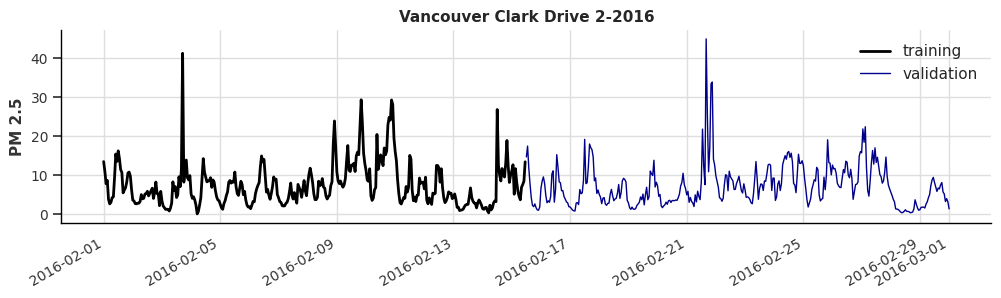

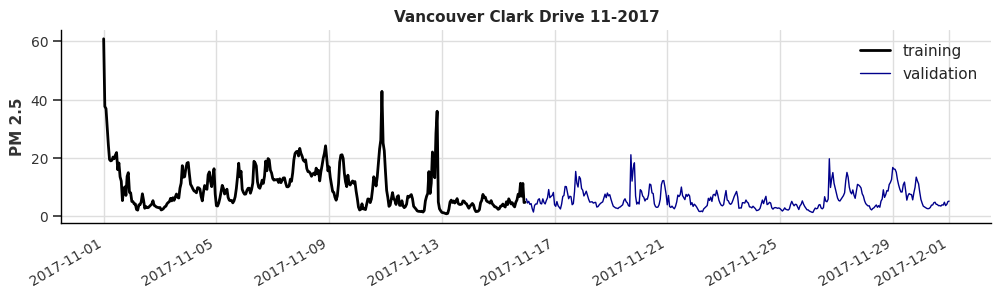

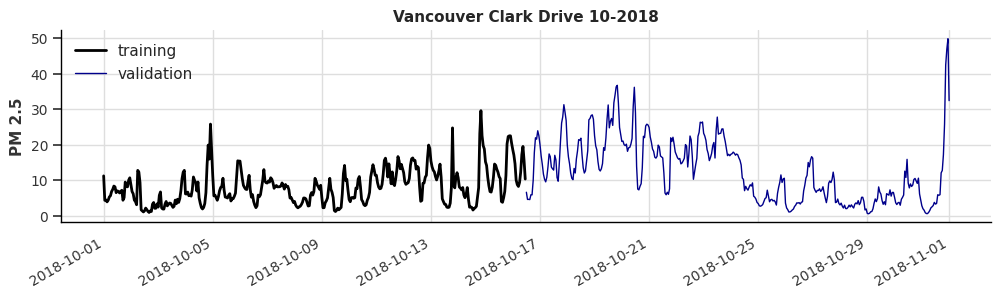

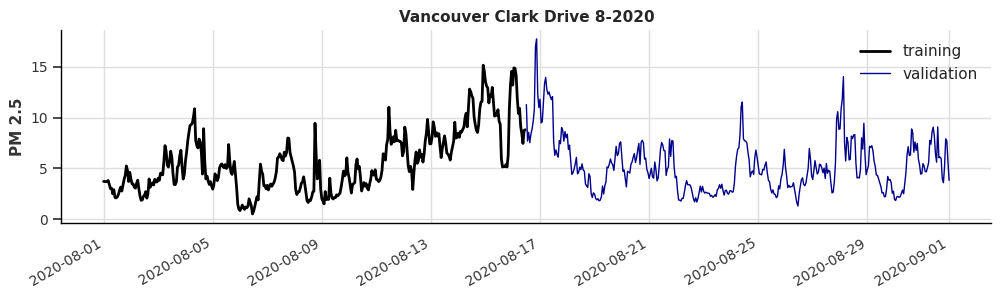

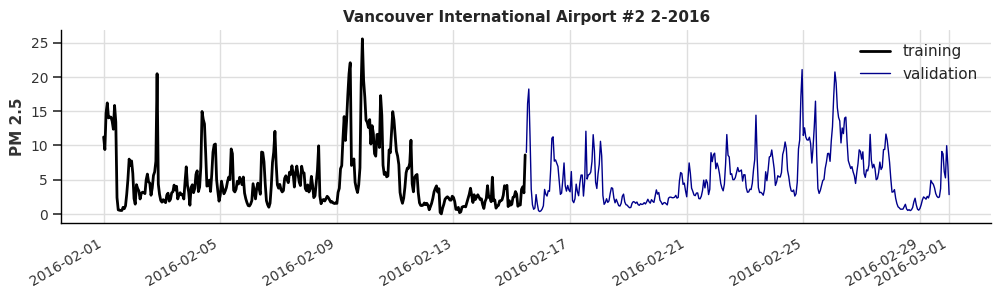

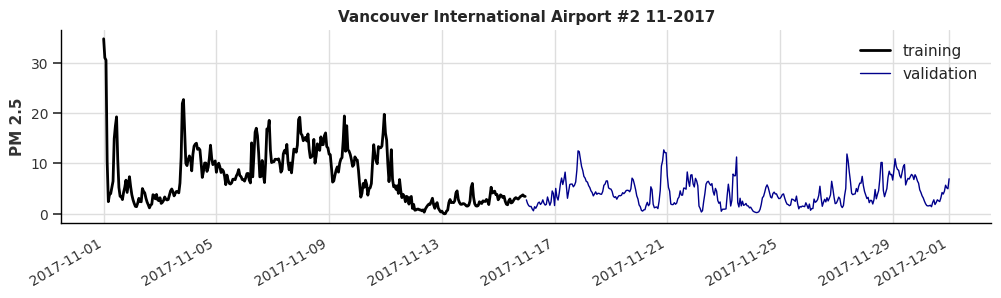

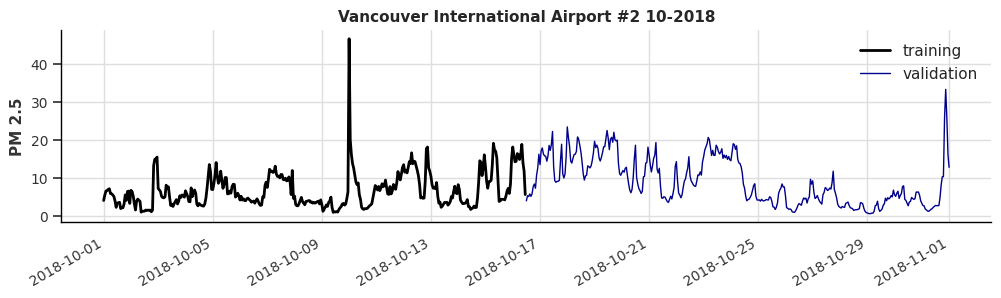

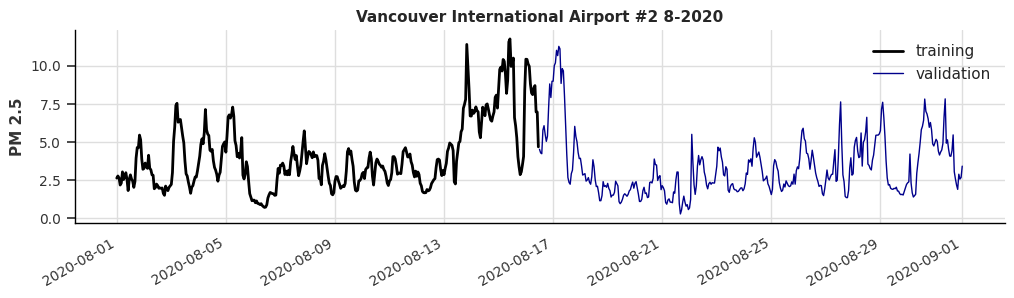

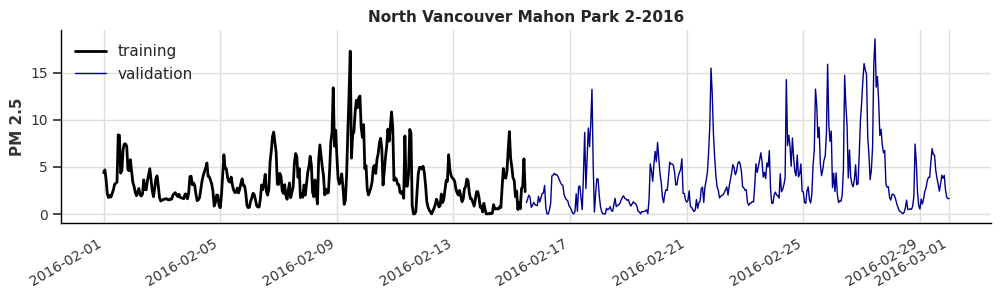

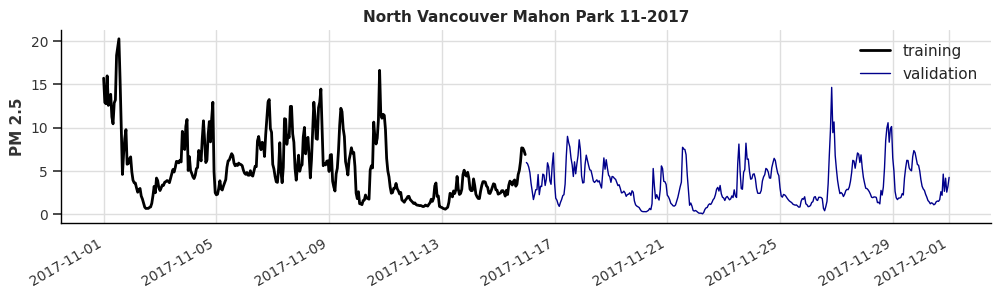

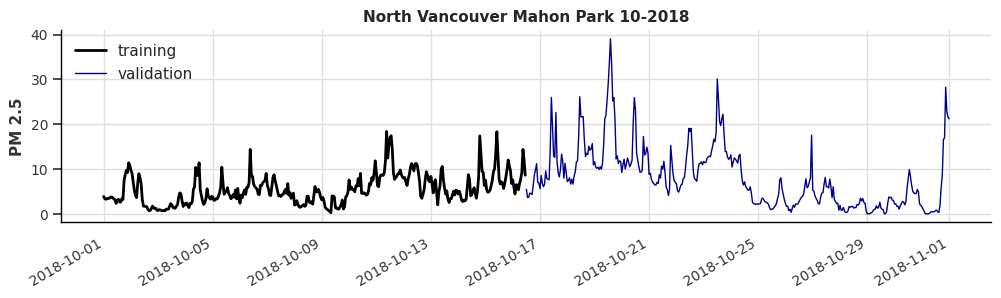

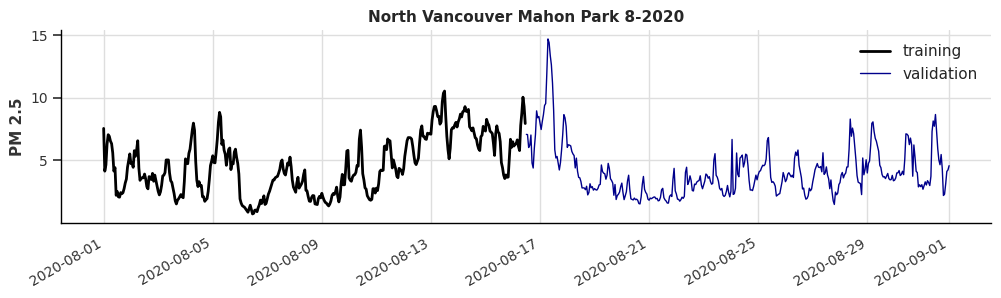

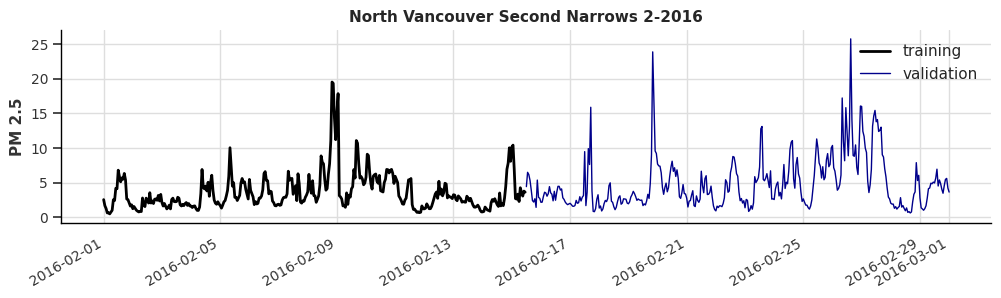

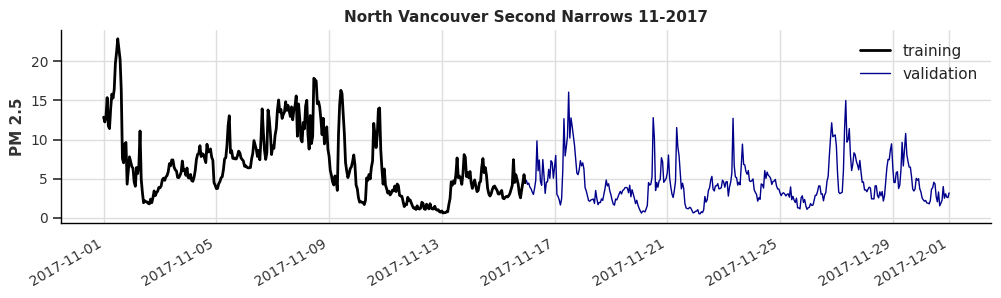

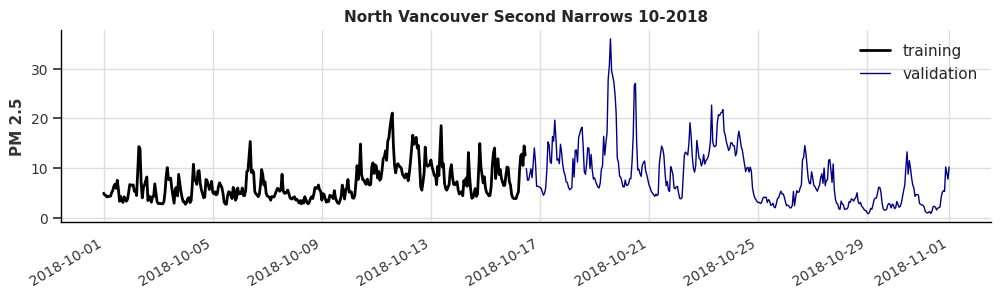

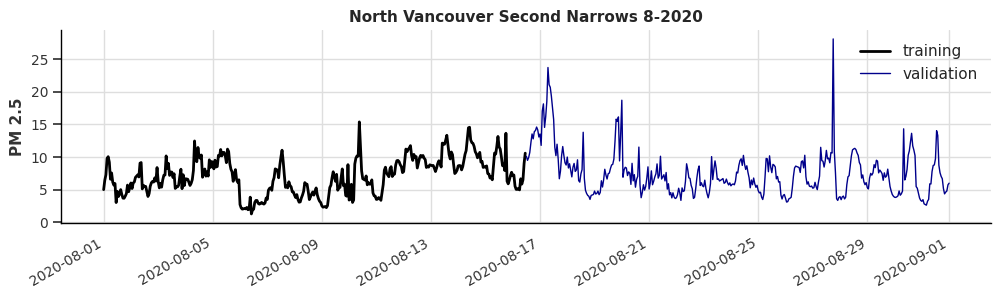

In [12]:
# Training and Validation sets
for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.5)

        # Darts training and validation plot
        dart_plot(train, val, station, month)

## Fast Fourier Transform
* Base model without amplitude filtering
* Base model filtering low-amplitude, high-frequency waves

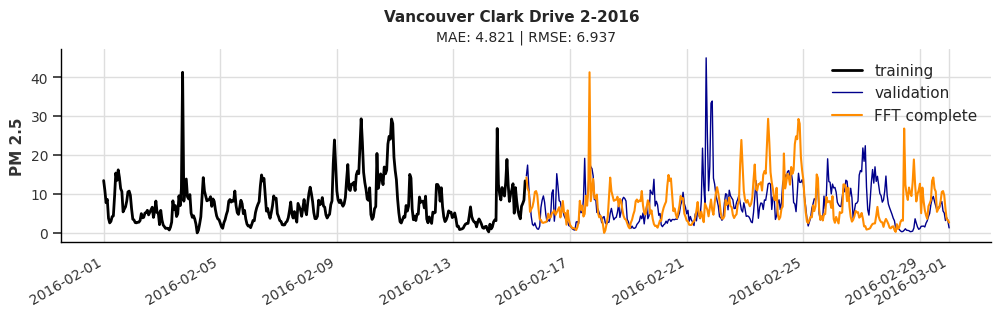

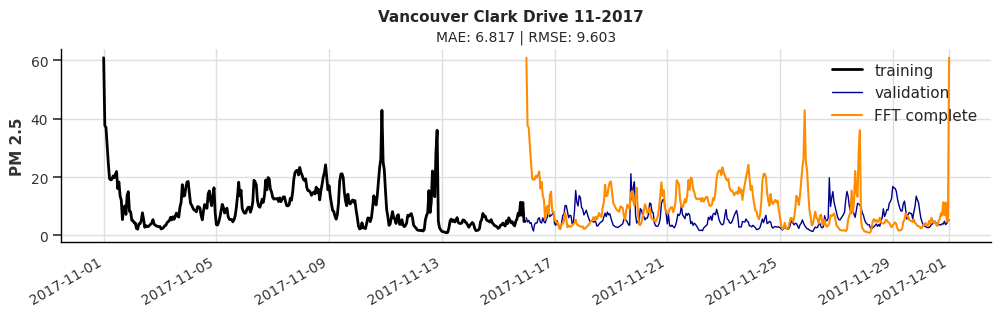

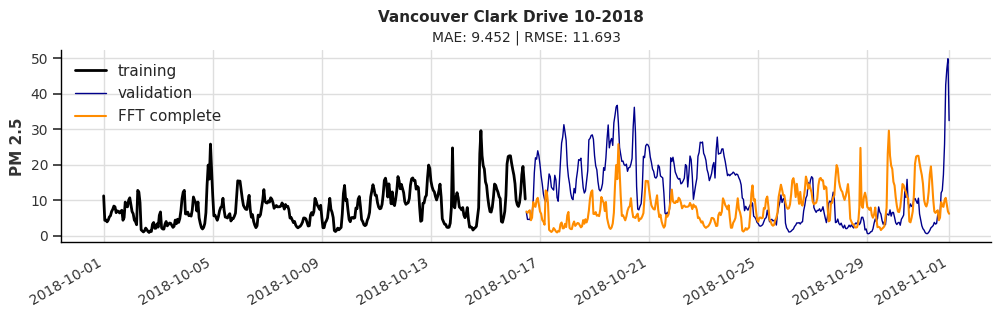

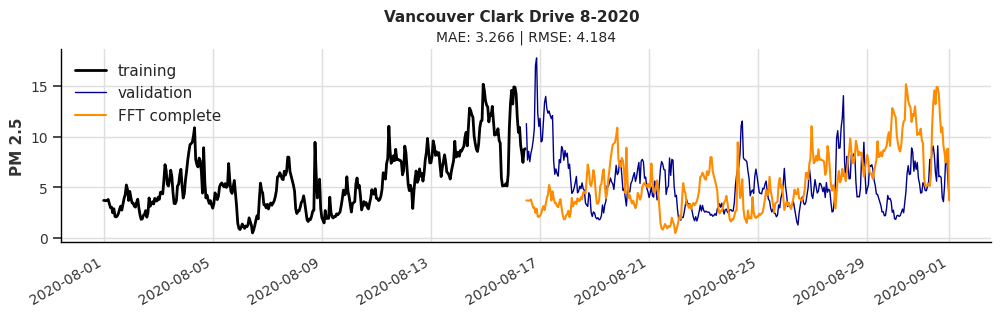

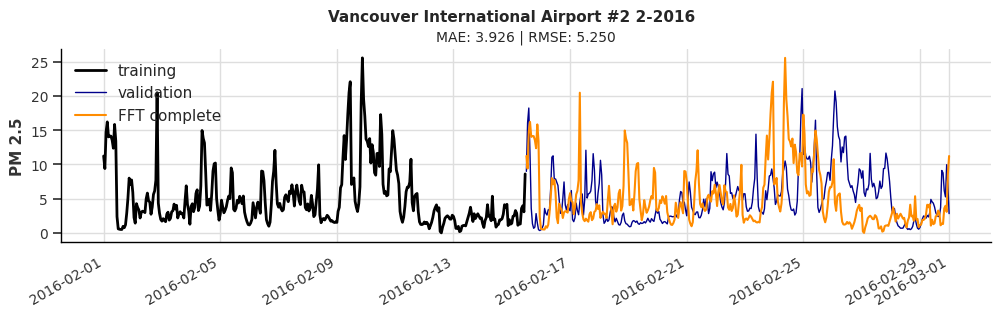

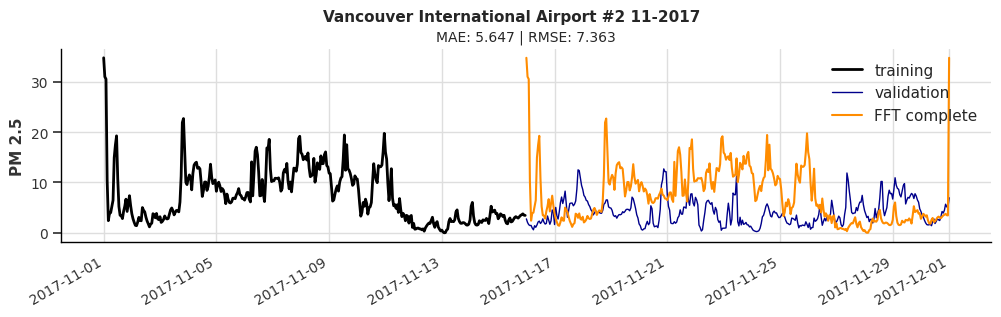

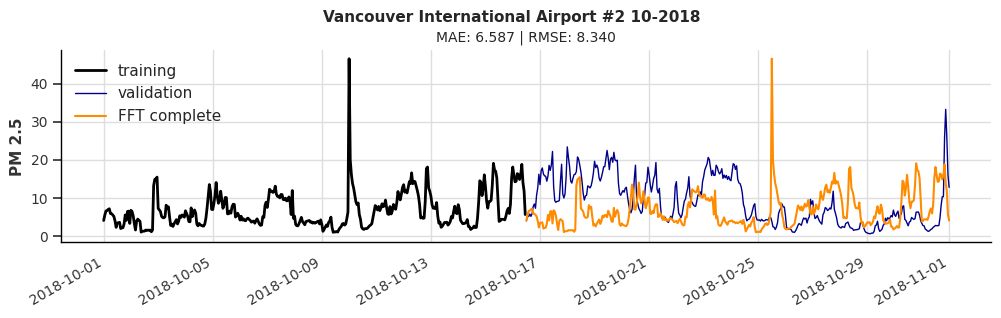

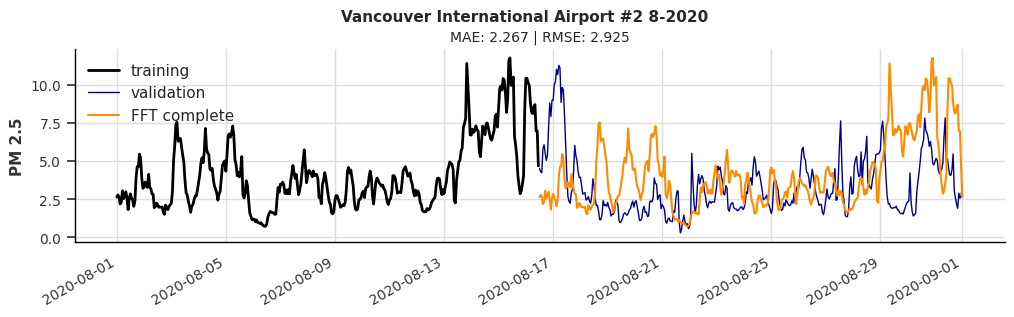

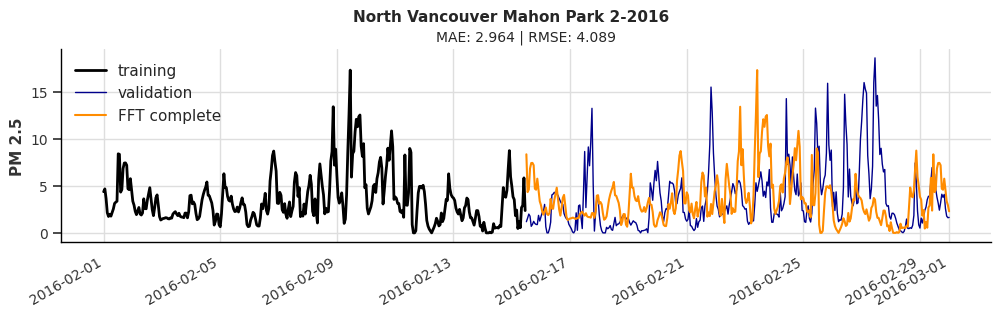

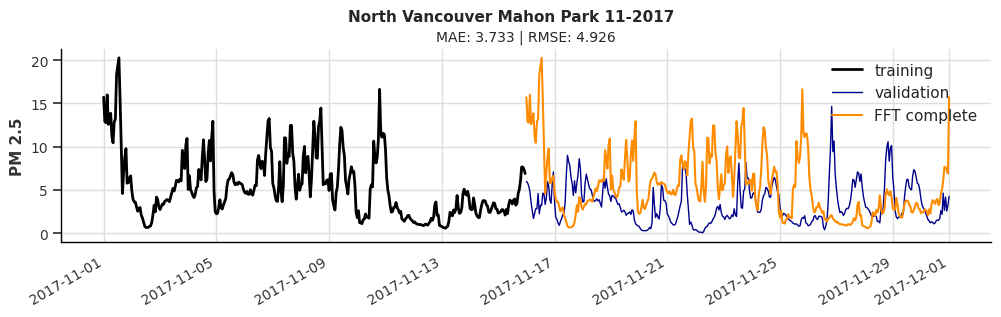

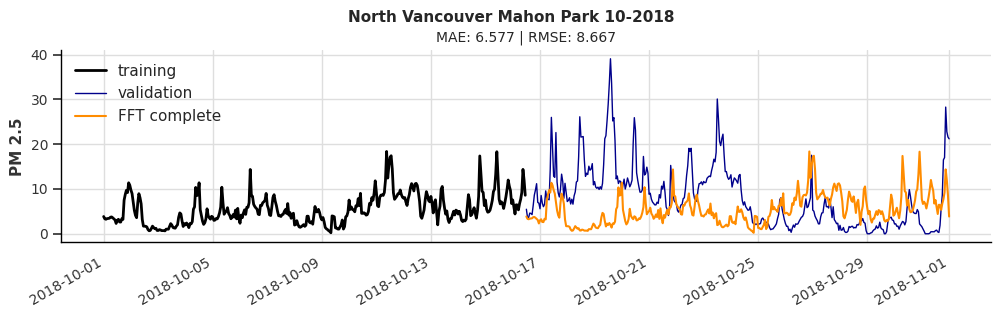

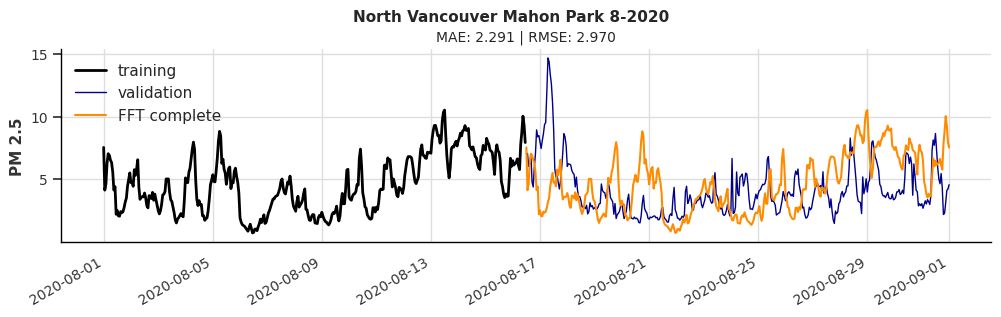

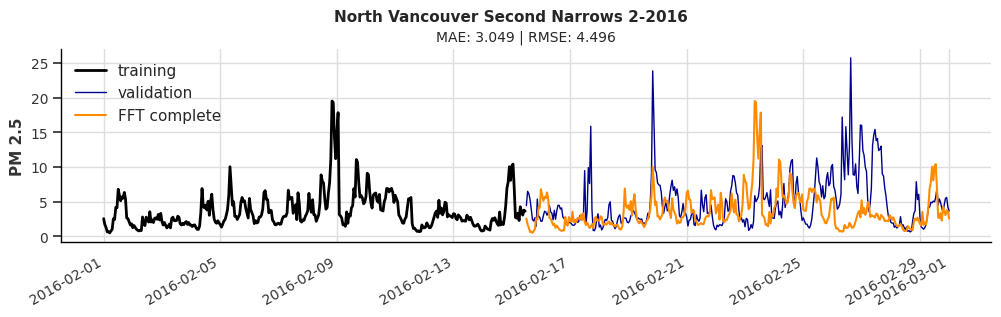

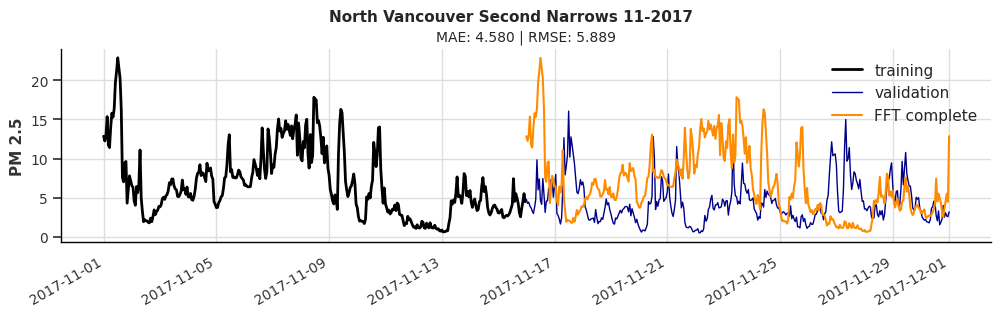

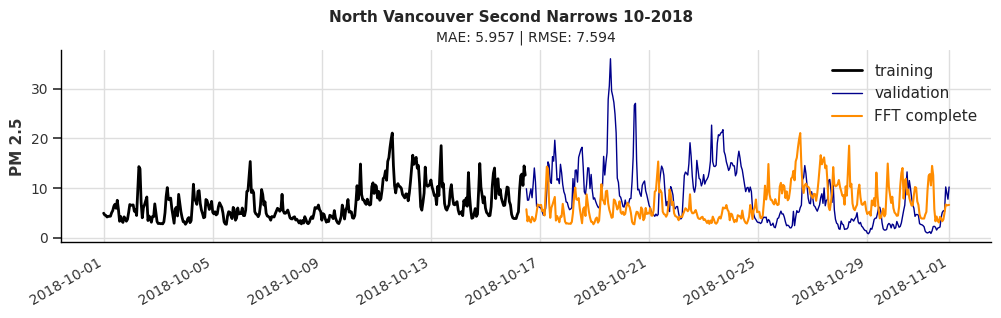

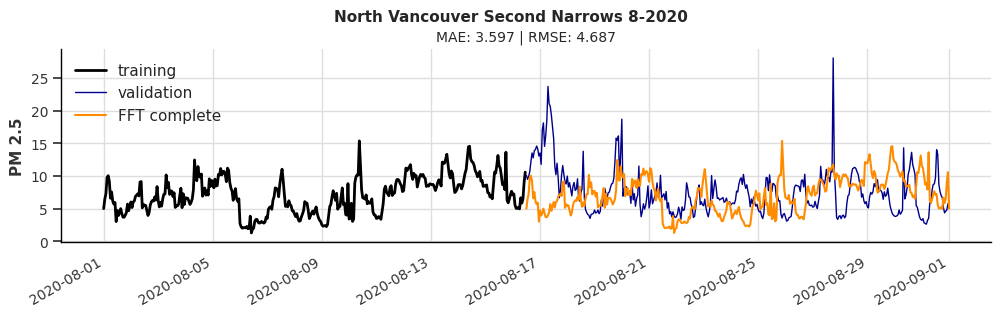

In [13]:
# Fast Fourier Transform without amplitude filtering
fft_model = FFT(nr_freqs_to_keep=None)

# Training and Validation sets
for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.5)

        fft_model.fit(train)
        pred_val = fft_model.predict(len(val))

        dart_plot(train, val, station, month, pred_val, pred_label="FFT complete")

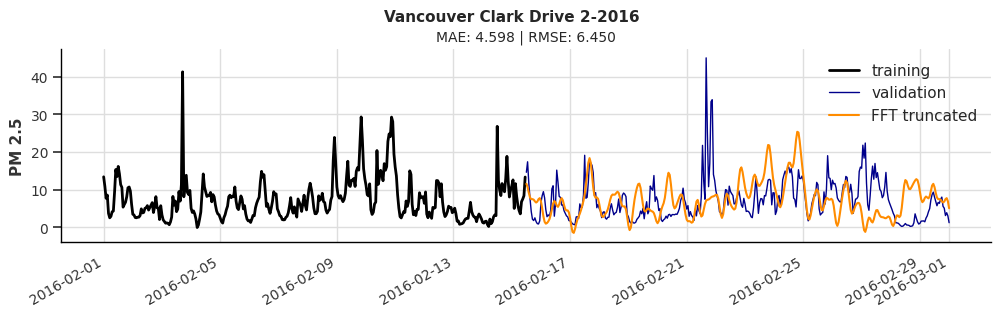

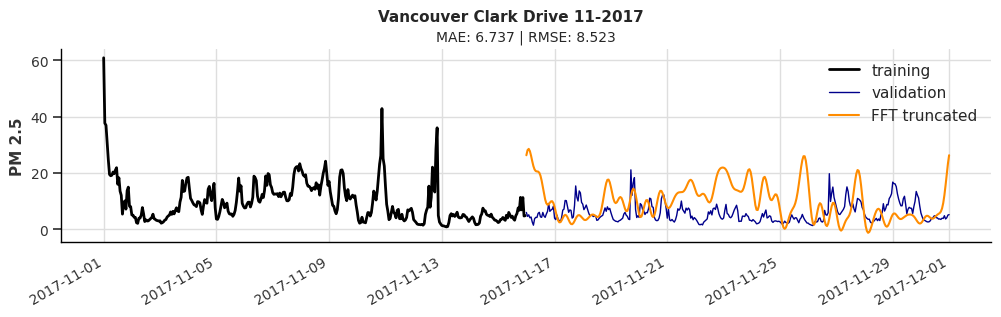

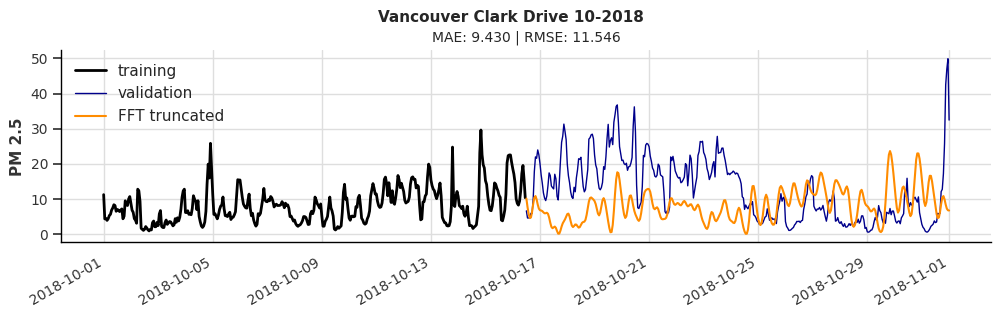

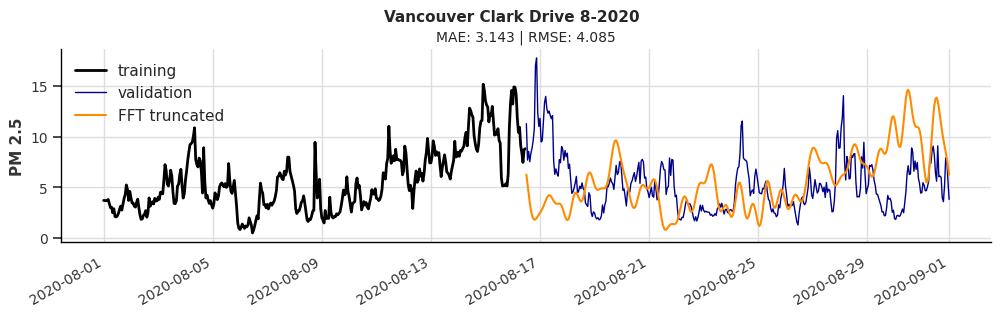

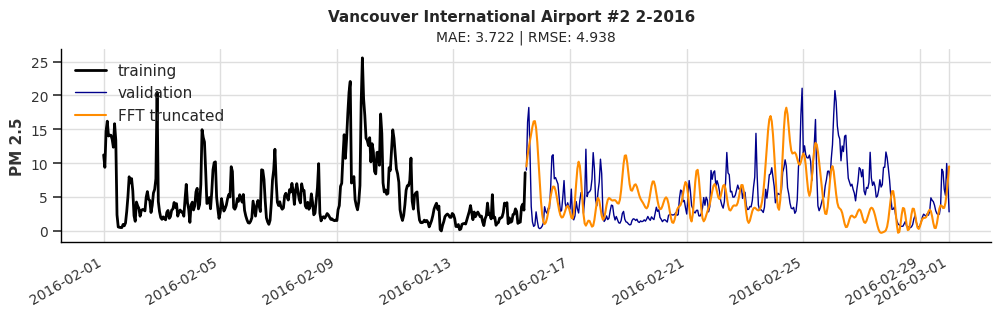

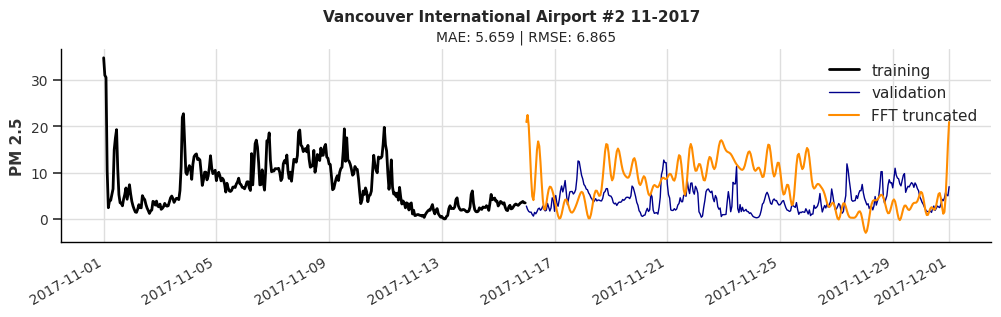

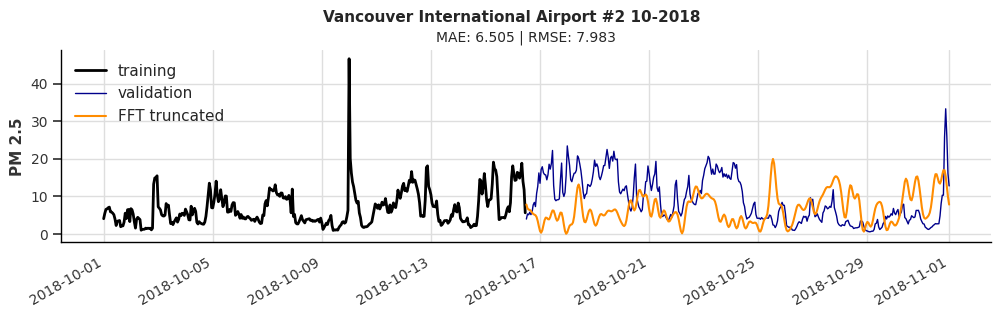

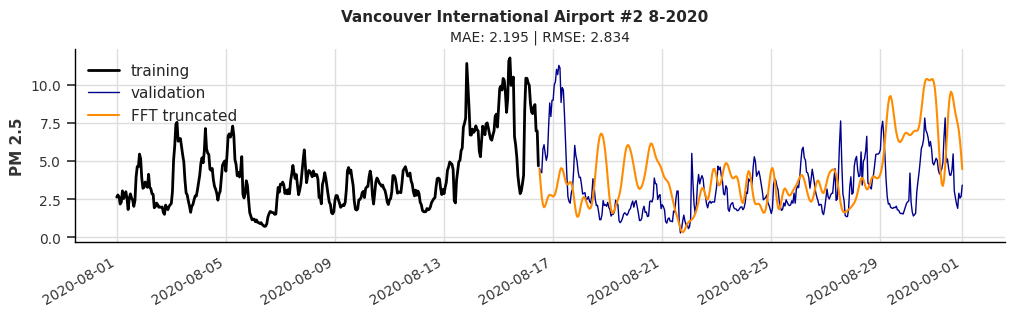

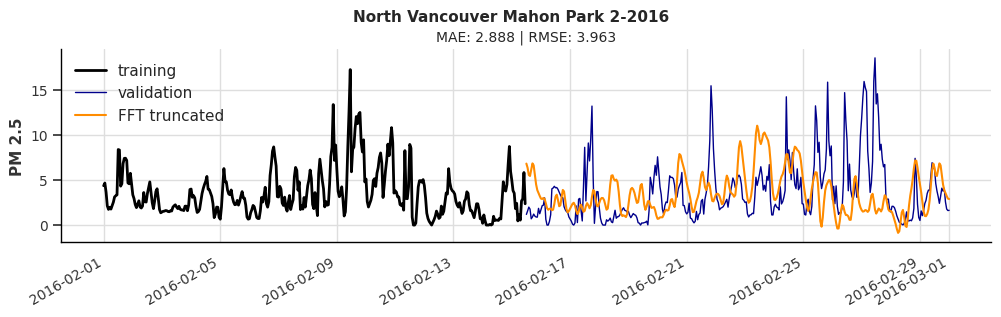

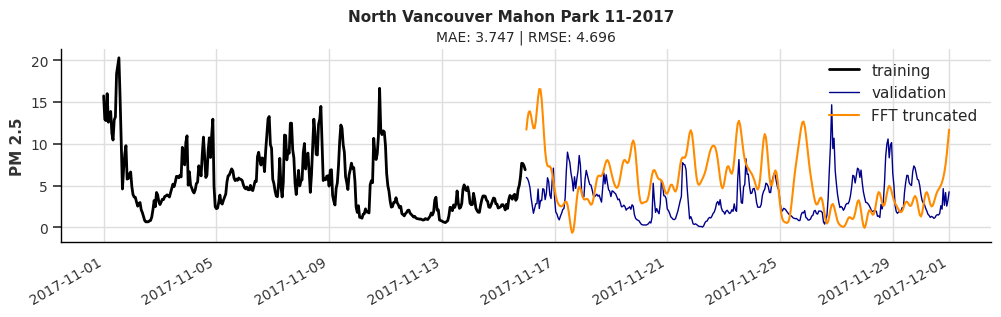

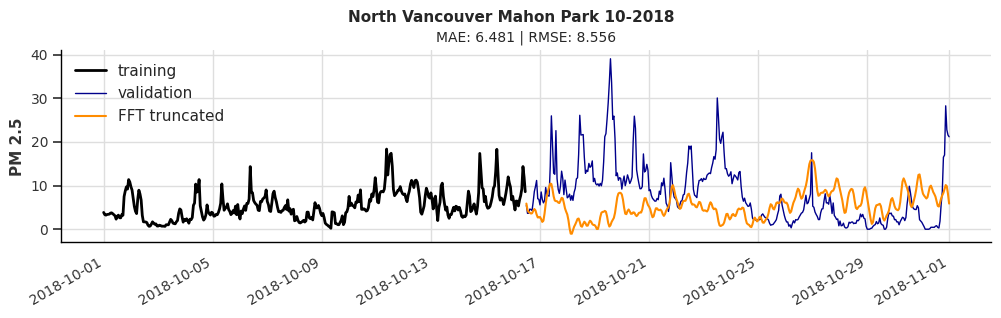

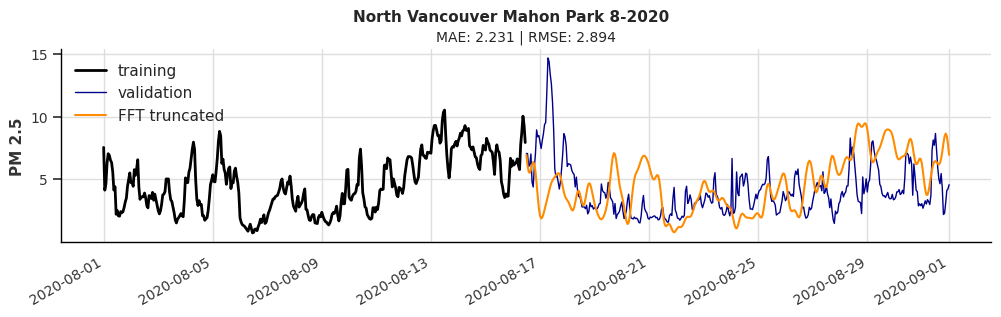

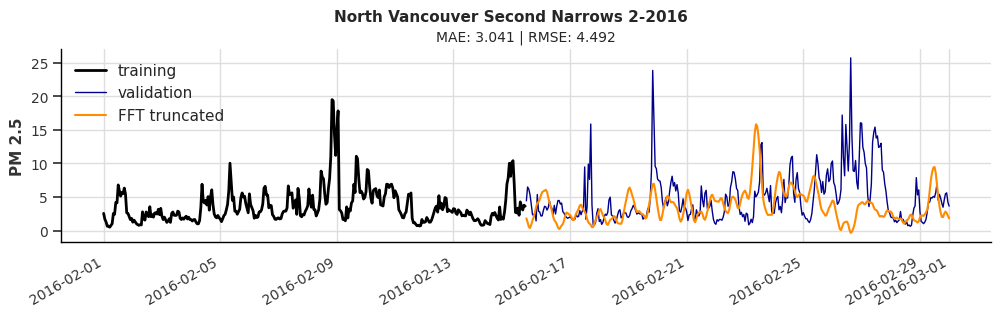

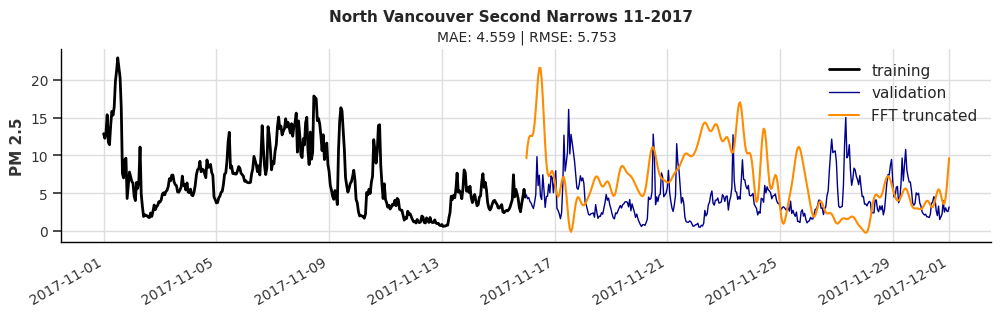

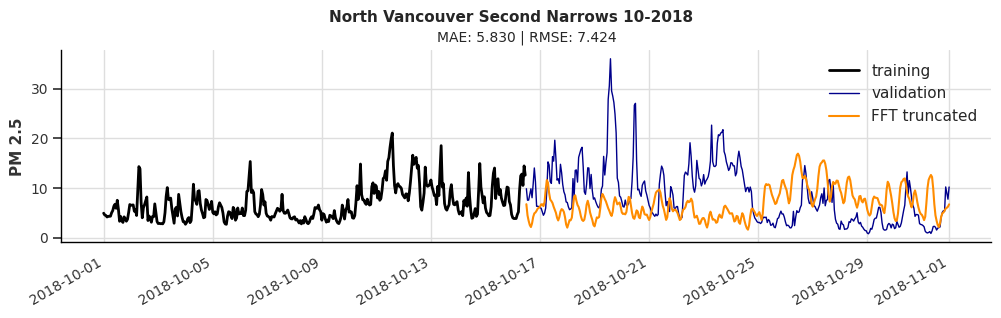

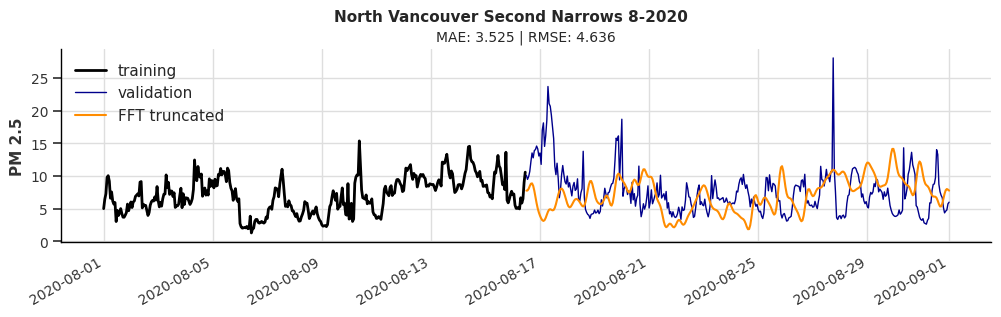

In [14]:
# Fast Fourier Transform without amplitude filtering
fft_model = FFT(nr_freqs_to_keep=50)

# Training and Validation sets
for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.5)

        fft_model.fit(train)
        pred_val = fft_model.predict(len(val))

        dart_plot(train, val, station, month, pred_val, pred_label="FFT truncated")

## LSTM
* Univariate LSTM
* LSTM with dateparts covariates

2022-11-05 13:41:53 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:41:53 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:41:53 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:41:53 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:41:53 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 42/42 [00:00<00:00, 48.97it/s, loss=4.12, v_num=logs, train_loss=3.970, val_loss=23.10]

2022-11-05 13:43:43 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


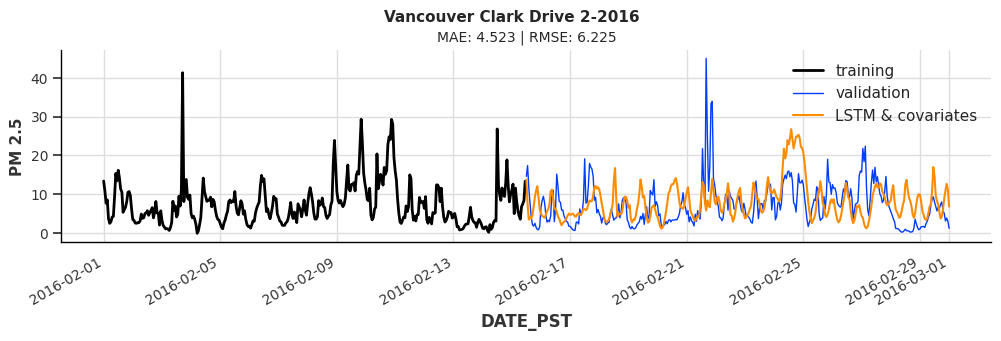

2022-11-05 13:43:43 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:43:43 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:43:43 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:43:43 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:43:43 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 44/44 [00:00<00:00, 46.79it/s, loss=2.97, v_num=logs, train_loss=1.930, val_loss=9.580]

2022-11-05 13:45:22 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


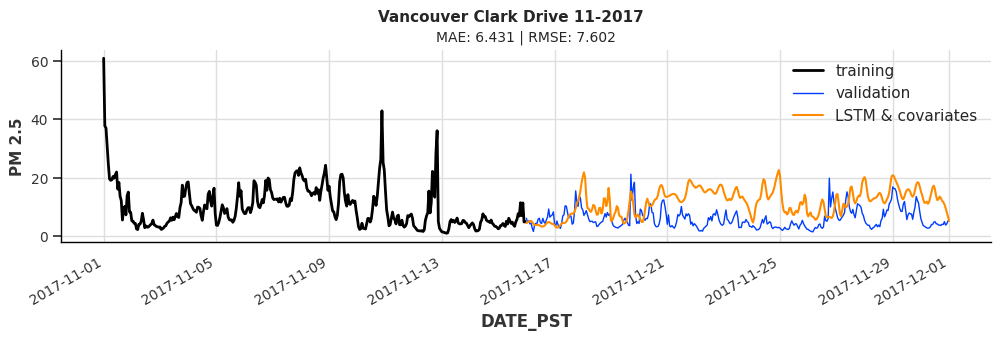

2022-11-05 13:45:23 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:45:23 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:45:23 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:45:23 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:45:23 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:00<00:00, 45.96it/s, loss=1.68, v_num=logs, train_loss=1.790, val_loss=24.10]

2022-11-05 13:47:03 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


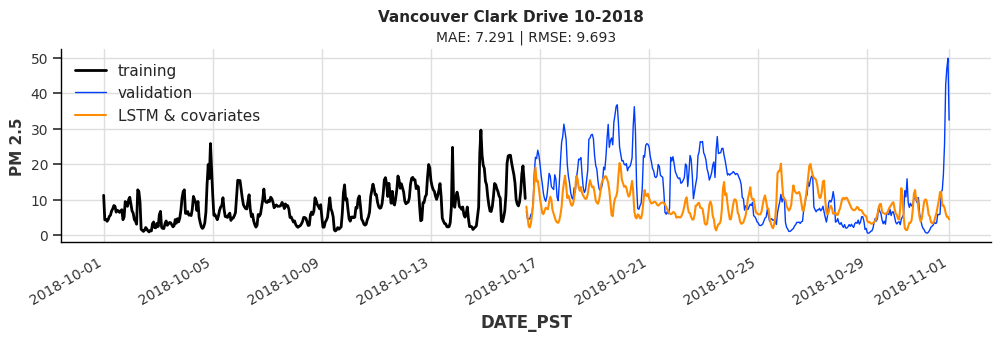

2022-11-05 13:47:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:47:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:47:04 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:47:04 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:47:04 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:00<00:00, 45.76it/s, loss=0.51, v_num=logs, train_loss=0.492, val_loss=1.900] 

2022-11-05 13:48:46 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


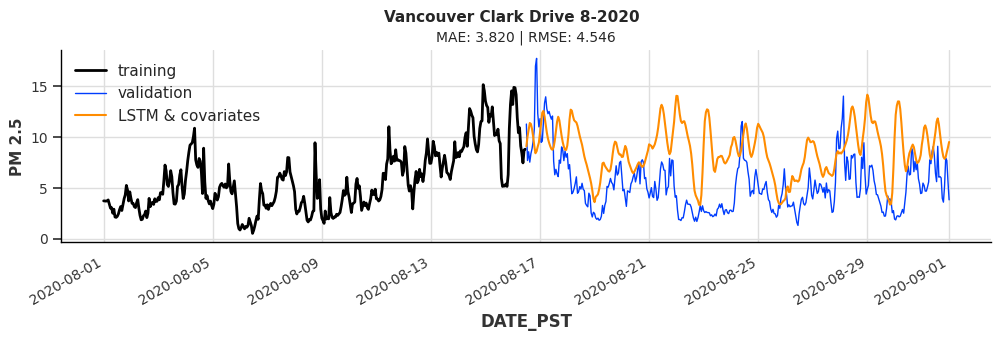

2022-11-05 13:48:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:48:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:48:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:48:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:48:46 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 42/42 [00:01<00:00, 41.76it/s, loss=1.44, v_num=logs, train_loss=2.160, val_loss=9.600]

2022-11-05 13:50:22 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]


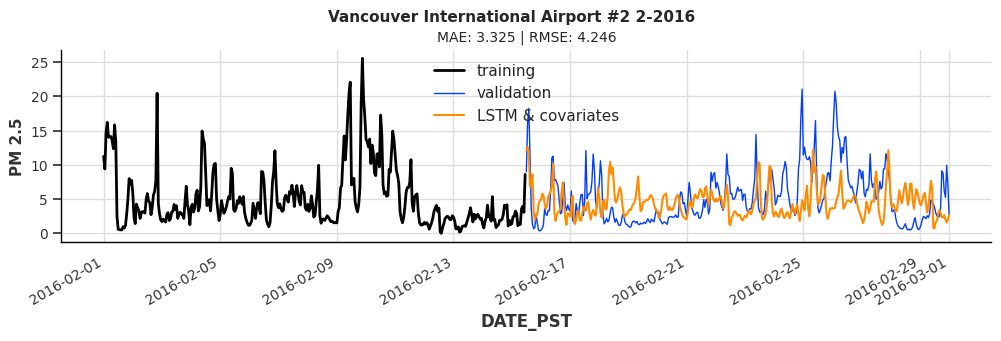

2022-11-05 13:50:22 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:50:22 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:50:22 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:50:22 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:50:23 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 44/44 [00:01<00:00, 42.45it/s, loss=1.46, v_num=logs, train_loss=2.150, val_loss=4.840]

2022-11-05 13:52:05 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


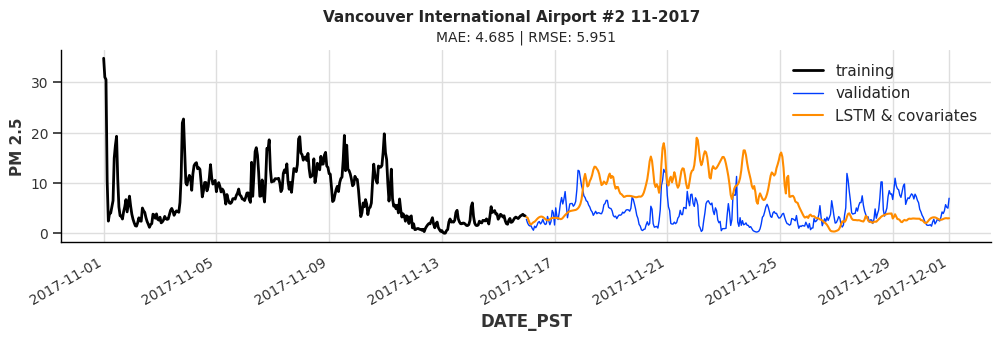

2022-11-05 13:52:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:52:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:52:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:52:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:52:06 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:01<00:00, 43.06it/s, loss=2.4, v_num=logs, train_loss=0.961, val_loss=11.10] 

2022-11-05 13:53:54 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


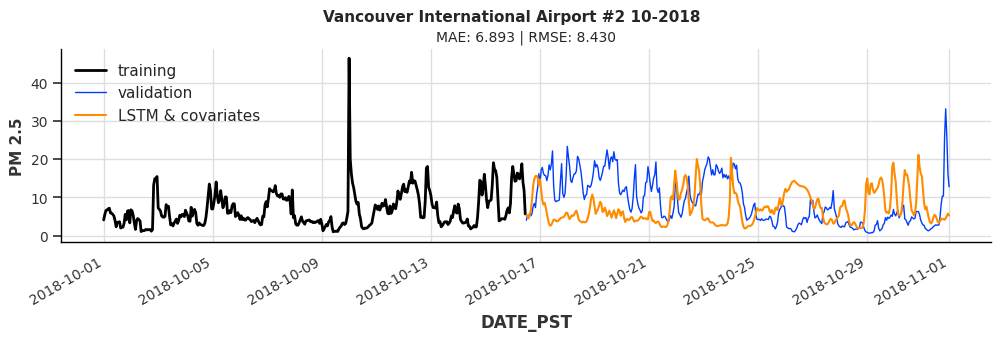

2022-11-05 13:53:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:53:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:53:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:53:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:53:55 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:01<00:00, 40.71it/s, loss=0.165, v_num=logs, train_loss=0.168, val_loss=0.882] 

2022-11-05 13:55:36 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


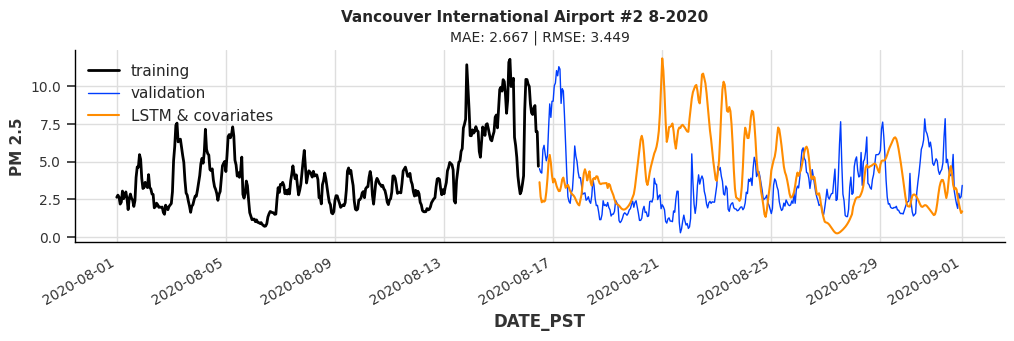

2022-11-05 13:55:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:55:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:55:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:55:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:55:37 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 42/42 [00:00<00:00, 48.50it/s, loss=0.572, v_num=logs, train_loss=1.190, val_loss=6.840]

2022-11-05 13:57:18 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


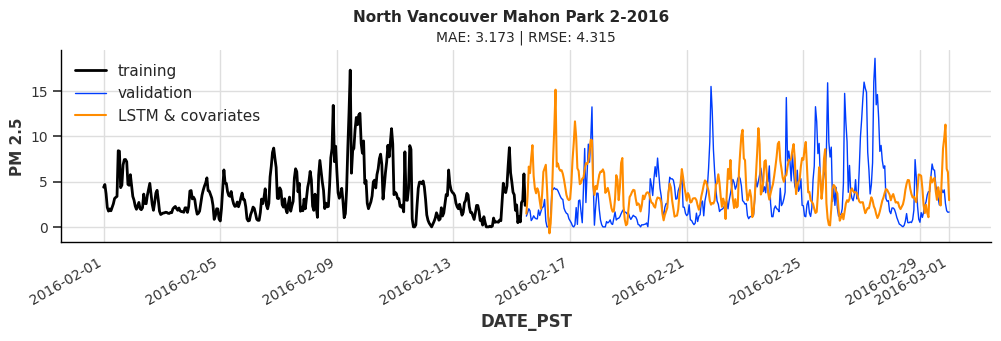

2022-11-05 13:57:18 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:57:18 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:57:18 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:57:18 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:57:18 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 44/44 [00:01<00:00, 41.79it/s, loss=0.577, v_num=logs, train_loss=0.799, val_loss=2.110]

2022-11-05 13:59:02 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


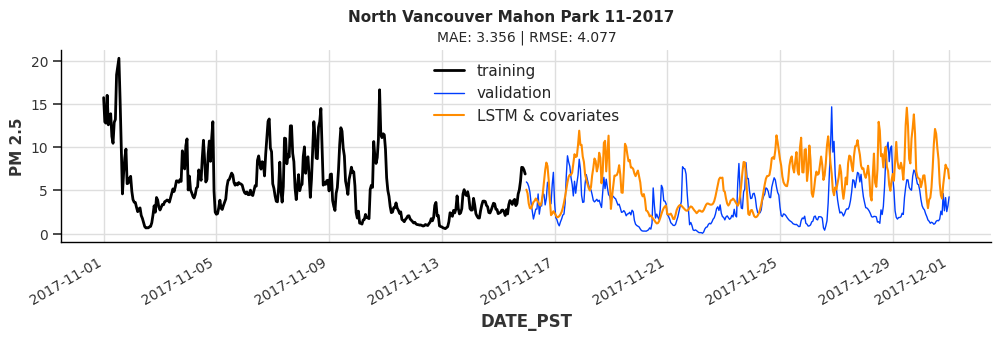

2022-11-05 13:59:02 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 13:59:02 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 13:59:02 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 13:59:02 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 13:59:02 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:00<00:00, 46.51it/s, loss=0.786, v_num=logs, train_loss=0.606, val_loss=13.80]

2022-11-05 14:00:42 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


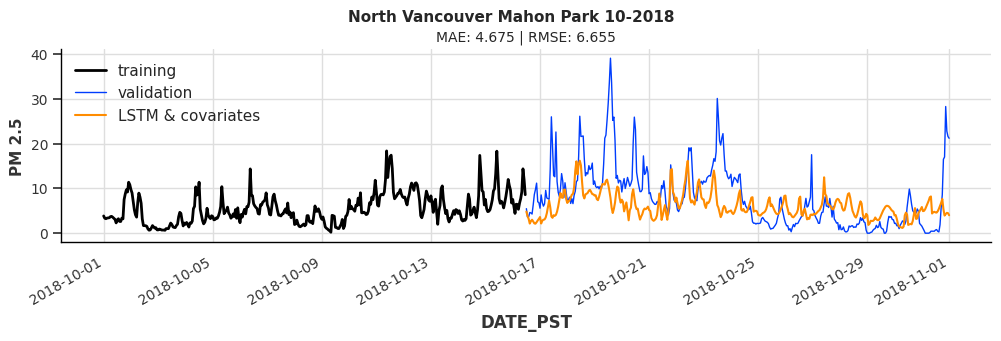

2022-11-05 14:00:43 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 14:00:43 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 14:00:43 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 14:00:43 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 14:00:43 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:00<00:00, 49.28it/s, loss=0.158, v_num=logs, train_loss=0.129, val_loss=1.060]

2022-11-05 14:02:23 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


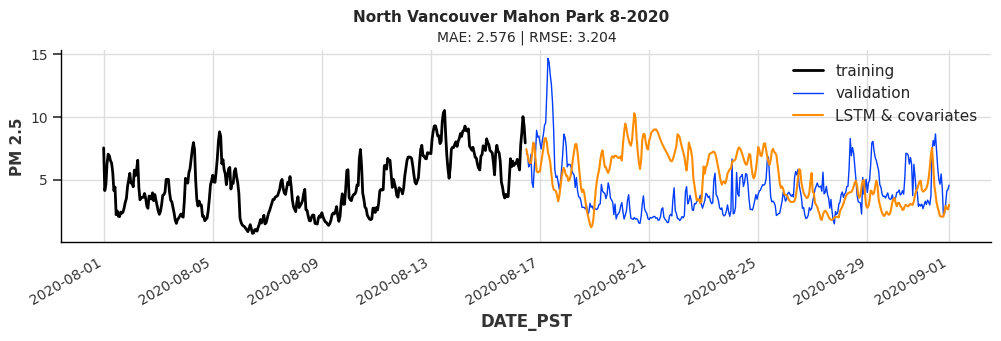

2022-11-05 14:02:23 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 14:02:23 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 14:02:23 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 14:02:23 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 14:02:24 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 42/42 [00:01<00:00, 41.42it/s, loss=0.561, v_num=logs, train_loss=0.950, val_loss=7.850]

2022-11-05 14:04:06 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


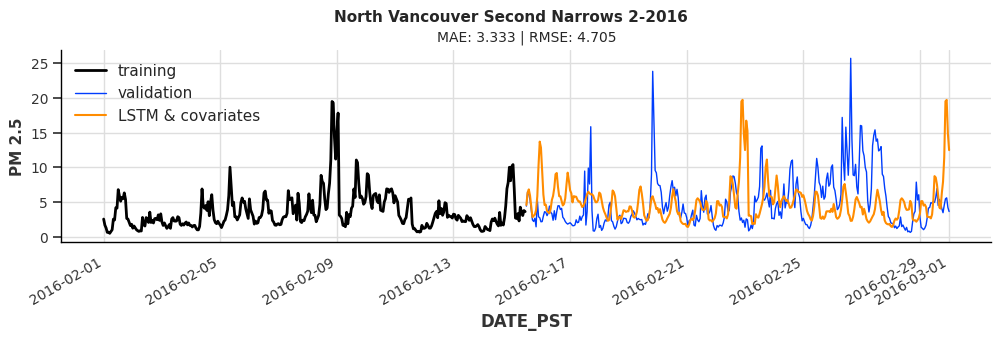

2022-11-05 14:04:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 14:04:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 14:04:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 14:04:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 14:04:06 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 44/44 [00:01<00:00, 43.79it/s, loss=0.845, v_num=logs, train_loss=0.736, val_loss=2.900]

2022-11-05 14:05:45 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


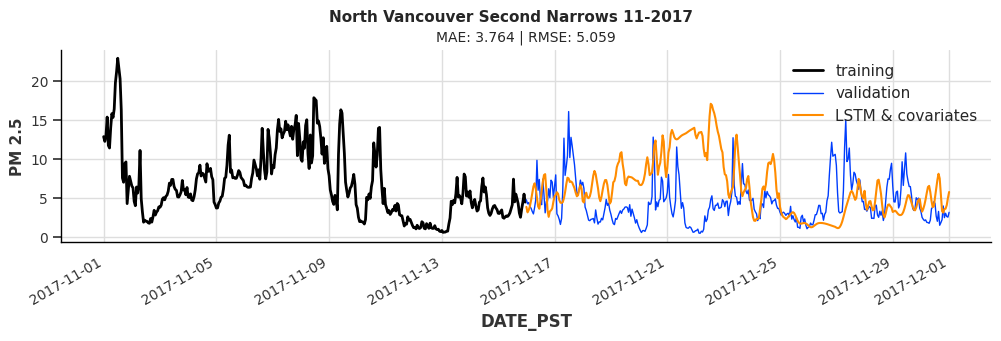

2022-11-05 14:05:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 14:05:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 14:05:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 14:05:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 14:05:47 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:00<00:00, 48.91it/s, loss=1.21, v_num=logs, train_loss=1.170, val_loss=11.70]

2022-11-05 14:07:28 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


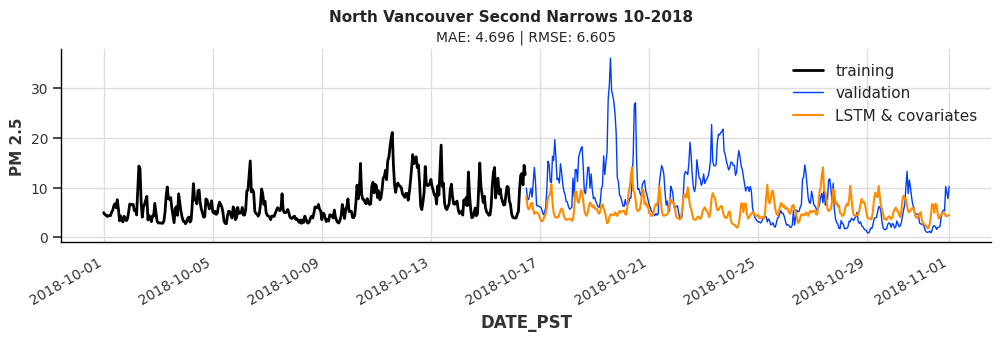

2022-11-05 14:07:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 14:07:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 14:07:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 14:07:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 14:07:28 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear           | 201   
---------------------------------------------------
169 K     Trainable params
0         Non-trainable params
169 K     Total params
1.352     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:01<00:00, 43.99it/s, loss=0.953, v_num=logs, train_loss=1.000, val_loss=5.480]

2022-11-05 14:09:14 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


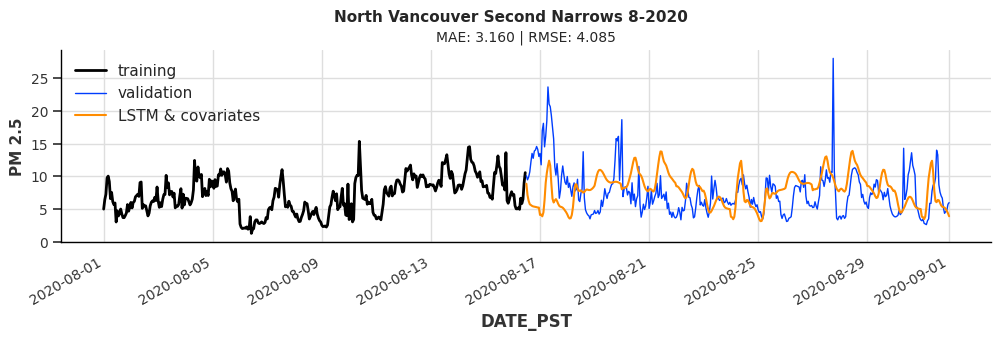

In [32]:
# LSTM with datepart covariates
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler

# LSTM
for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.5)

        ## Creating month, year, and day-of-week covariates
        # Year covariates
        year_series = datetime_attribute_timeseries(
            pd.date_range(start=series.start_time(),
                            freq=series.freq_str,
                            periods=len(series)),
            attribute="year",
            one_hot=False,
        )

        # Weekday covariates
        weekday_series = datetime_attribute_timeseries(
            year_series, attribute="weekday", one_hot=True
        )

        # Hour covariates
        hour_series = datetime_attribute_timeseries(
            year_series, attribute="hour", one_hot=False
        )
        # Scaling hour covariates
        hour_series = Scaler().fit_transform(hour_series)

        covariates = weekday_series.stack(hour_series)
        cov_train, cov_val = covariates.split_before(0.5)

        model_name = f"LSTM_{month}_{station}"

        # LSTM model
        my_model = RNNModel(
            model="LSTM",
            hidden_dim=200,
            dropout=0.1,
            batch_size=16,
            n_epochs=100,
            optimizer_kwargs={"lr": 5e-4},
            model_name=model_name,
            log_tensorboard=True,
            random_state=123,
            training_length=20,
            input_chunk_length=21,
            force_reset=True,
            save_checkpoints=True,
        )

        # Training
        my_model.fit(
            train,
            future_covariates=covariates,
            val_series=val,
            val_future_covariates=covariates,
            verbose=True,
        )

        # Validation
        pred_val = my_model.predict(n=len(val), future_covariates=covariates)
        my_model.load_from_checkpoint(model_name=model_name, best=True)
        dart_plot(train, val, station, month, pred_val, pred_label="LSTM & covariates")

## Long term dependency
* Iterating on increasing training site range

In [19]:
# Iterating through 2 to 6 months prior
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

months_prior = [2, 3, 4, 5, 6]
results_dict = {}

for month_prior in months_prior:
    # Subsetting
    station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
    subset = station_subset.loc[datetime(2020, 9 - month_prior, 1):datetime(2020, 9, 1), "PM 2.5"]
    series = TimeSeries.from_dataframe(subset.to_frame().interpolate())

    train, val = series.split_before(pd.Timestamp(datetime(2020, 8, 15)))

    ## Creating month, year, and day-of-week covariates
    # Year covariates
    year_series = datetime_attribute_timeseries(
        pd.date_range(start=series.start_time(),
                        freq=series.freq_str,
                        periods=len(series)),
        attribute="year",
        one_hot=False,
    )

    # Weekday covariates
    weekday_series = datetime_attribute_timeseries(
        year_series, attribute="weekday", one_hot=True
    )

    # Hour covariates
    hour_series = datetime_attribute_timeseries(
        year_series, attribute="hour", one_hot=False
    )
    # Scaling hour covariates
    hour_series = Scaler().fit_transform(hour_series)

    covariates = weekday_series.stack(hour_series)
    cov_train, cov_val = covariates.split_before(pd.Timestamp(datetime(2020, 8, 15)))

    model_name = f"LSTM_{month_prior}-months_training_batch32"
    results_dict[model_name] = {}

    # Early stopping
    stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.02,
        mode="min"
    )

    # LSTM model
    my_model = RNNModel(
        model="LSTM",
        hidden_dim=200,
        dropout=0.1,
        batch_size=32,
        n_epochs=100,
        optimizer_kwargs={"lr": 5e-4},
        model_name=model_name,
        log_tensorboard=True,
        random_state=123,
        training_length=20,
        input_chunk_length=21,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs={
            "callbacks": [stopper],
            "accelerator": "gpu",
            "devices": -1,
            "auto_select_gpus": True
        }
    )

    # Training
    my_model.fit(
        train,
        future_covariates=covariates,
        val_series=val,
        val_future_covariates=covariates,
        verbose=True,
    )

    # Validation
    pred_val = my_model.predict(n=len(val), future_covariates=covariates)
    my_model.load_from_checkpoint(model_name=model_name, best=True)

    # Storing results
    results_dict[model_name]["covariates"] = covariates
    results_dict[model_name]["train"] = train
    results_dict[model_name]["val"] = val
    results_dict[model_name]["pred_val"] = pred_val
    results_dict[model_name]["MAE"] = mae(pred_val, val)
    results_dict[model_name]["RMSE"] = rmse(pred_val, val)

    # Visualization
    # dart_plot(train, val, station, month, pred_val, pred_label="LSTM & covariates")

2022-11-08 12:48:35 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 12:48:35 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 12:48:35 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 12:48:35 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 12:48:35 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 12:48:36 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 12:48:36 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear    

Epoch 32: 100%|██████████| 47/47 [00:01<00:00, 46.26it/s, loss=1.88, v_num=logs, train_loss=2.030, val_loss=4.340]


2022-11-08 12:49:13 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


2022-11-08 12:49:14 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 12:49:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 12:49:14 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 12:49:14 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 12:49:14 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 12:49:14 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 12:49:14 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear    

Epoch 24: 100%|██████████| 69/69 [00:01<00:00, 45.21it/s, loss=2.24, v_num=logs, train_loss=1.710, val_loss=4.440]


2022-11-08 12:49:55 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


2022-11-08 12:49:55 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 12:49:55 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 12:49:55 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 12:49:55 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 12:49:55 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 12:49:55 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 12:49:55 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear    

Epoch 18: 100%|██████████| 92/92 [00:02<00:00, 36.15it/s, loss=2.65, v_num=logs, train_loss=2.110, val_loss=4.430]


2022-11-08 12:50:38 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


2022-11-08 12:50:38 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 12:50:39 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 12:50:39 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 12:50:39 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 12:50:39 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 12:50:39 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 12:50:39 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear    

Epoch 16: 100%|██████████| 115/115 [00:02<00:00, 41.51it/s, loss=3.17, v_num=logs, train_loss=2.120, val_loss=4.410]


2022-11-08 12:51:27 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


2022-11-08 12:51:27 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 12:51:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 12:51:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 12:51:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 12:51:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 12:51:27 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 12:51:27 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear    

Epoch 15: 100%|██████████| 138/138 [00:03<00:00, 44.66it/s, loss=3.19, v_num=logs, train_loss=2.680, val_loss=4.250]


2022-11-08 12:52:21 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


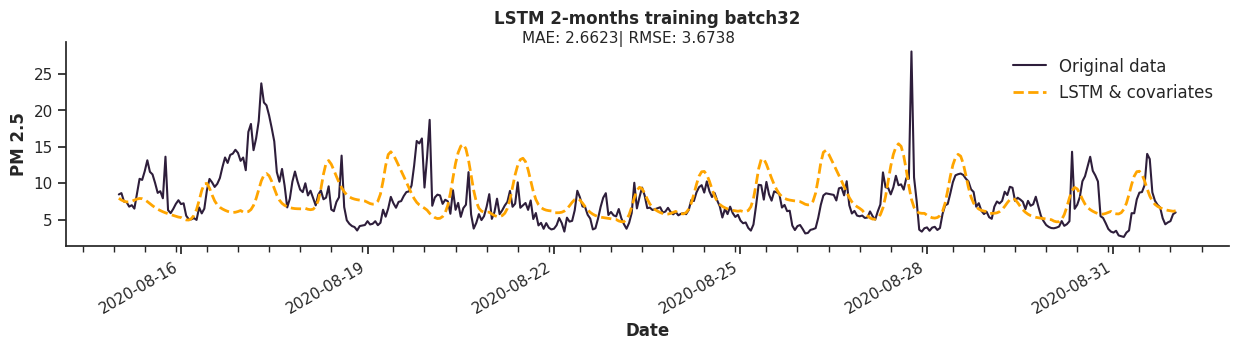

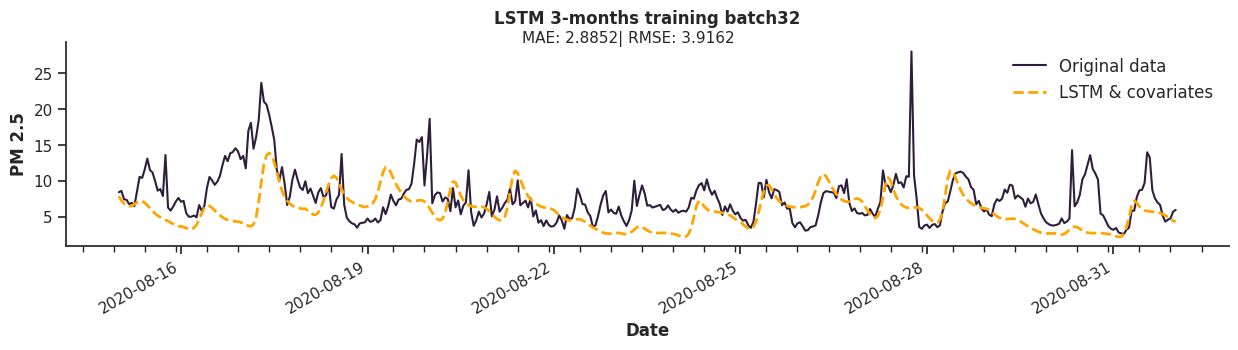

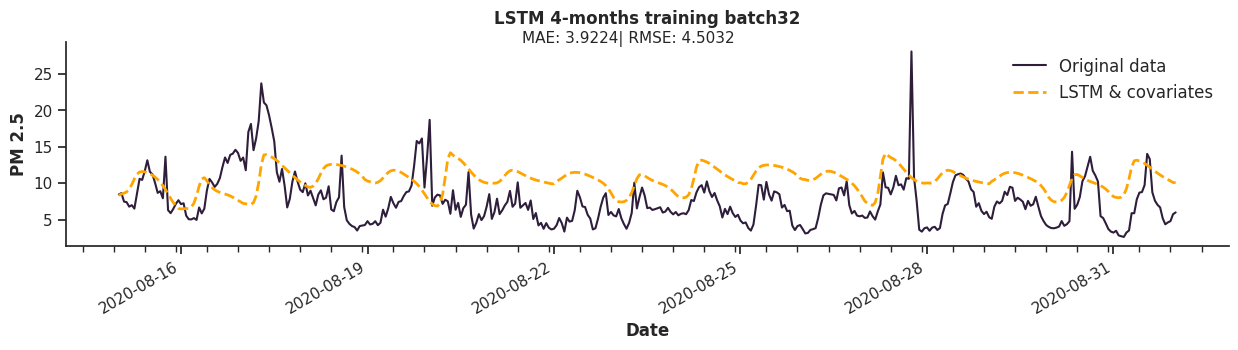

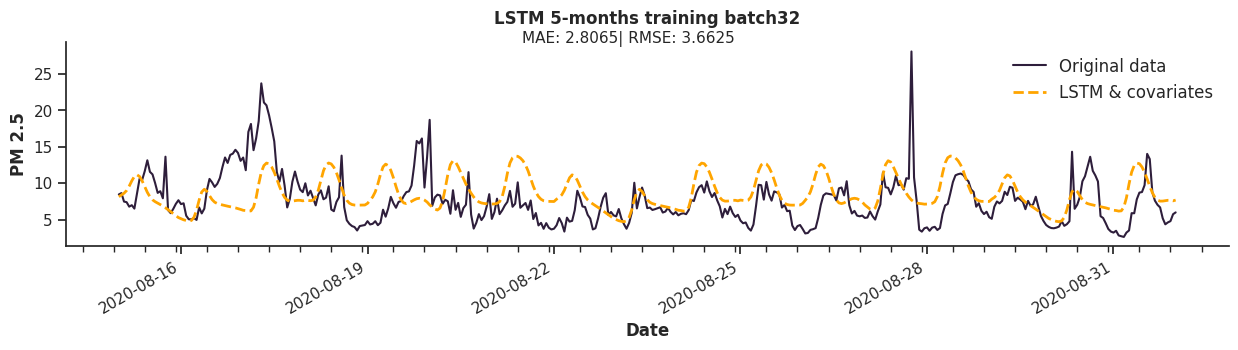

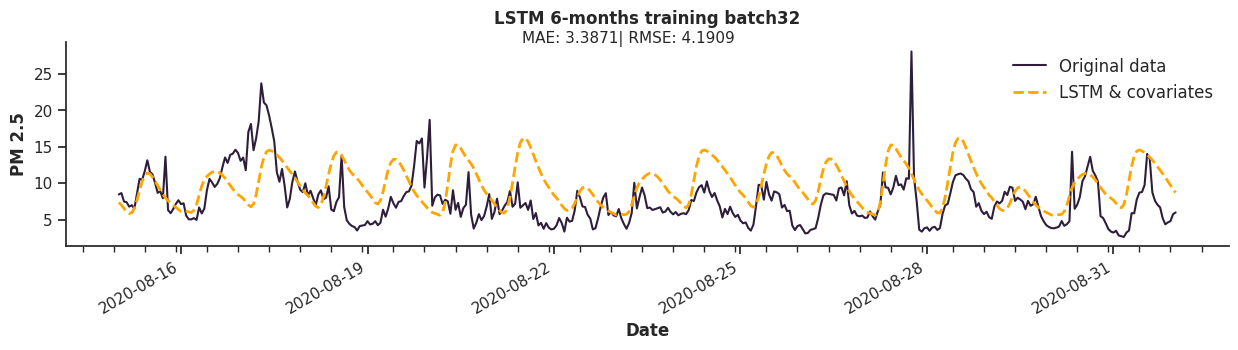

In [20]:
from tshelpers.plot import plot_compare
from tshelpers.metrics import mae_score, rmse_score

for model in results_dict.keys():
    val = results_dict[model]["val"]
    pred_val = results_dict[model]["pred_val"]

    val_df = pd.DataFrame({"DATE_PST": val.time_index, "PM 2.5": [i[0] for i in val.values()]}).set_index("DATE_PST", drop=True)
    pred_df = pd.DataFrame({"DATE_PST": pred_val.time_index, "PM 2.5": [i[0] for i in pred_val.values()]}).set_index("DATE_PST", drop=True)

    plot_compare(
        pred_df,
        val_df,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=False,
        fill=False,
        data_label="LSTM & covariates",
        data_missing_label="Original data",
        plot_title=str(model).replace("_", " "),
        plot_sup_title=f"MAE: {mae_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

In [23]:
# Optimizing model complexity
hidden_dims = [200, 300, 400, 500]
results_dict = {}

for hidden_dim in hidden_dims:
    # Subsetting
    station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
    subset = station_subset.loc[datetime(2020, 7, 1):datetime(2020, 9, 1), "PM 2.5"]
    series = TimeSeries.from_dataframe(subset.to_frame().interpolate())

    train, val = series.split_before(pd.Timestamp(datetime(2020, 8, 15)))

    ## Creating month, year, and day-of-week covariates
    # Year covariates
    year_series = datetime_attribute_timeseries(
        pd.date_range(start=series.start_time(),
                        freq=series.freq_str,
                        periods=len(series)),
        attribute="year",
        one_hot=False,
    )

    # Weekday covariates
    weekday_series = datetime_attribute_timeseries(
        year_series, attribute="weekday", one_hot=True
    )

    # Hour covariates
    hour_series = datetime_attribute_timeseries(
        year_series, attribute="hour", one_hot=False
    )
    # Scaling hour covariates
    hour_series = Scaler().fit_transform(hour_series)

    covariates = weekday_series.stack(hour_series)
    cov_train, cov_val = covariates.split_before(pd.Timestamp(datetime(2020, 8, 15)))

    model_name = f"LSTM_2-months_training_batch32_{hidden_dim}-hidden_dim"
    results_dict[model_name] = {}

    # Early stopping
    stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.02,
        mode="min"
    )

    # LSTM model
    my_model = RNNModel(
        model="LSTM",
        hidden_dim=hidden_dim,
        dropout=0.1,
        batch_size=32,
        n_epochs=100,
        optimizer_kwargs={"lr": 5e-4},
        model_name=model_name,
        log_tensorboard=True,
        random_state=123,
        training_length=20,
        input_chunk_length=21,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs={
            "callbacks": [stopper],
            "accelerator": "gpu",
            "devices": -1,
            "auto_select_gpus": True
        }
    )

    # Training
    my_model.fit(
        train,
        future_covariates=covariates,
        val_series=val,
        val_future_covariates=covariates,
        verbose=True,
    )

    # Validation
    pred_val = my_model.predict(n=len(val), future_covariates=covariates)
    my_model.load_from_checkpoint(model_name=model_name, best=True)

    # Storing results
    results_dict[model_name]["covariates"] = covariates
    results_dict[model_name]["train"] = train
    results_dict[model_name]["val"] = val
    results_dict[model_name]["pred_val"] = pred_val
    results_dict[model_name]["MAE"] = mae(pred_val, val)
    results_dict[model_name]["RMSE"] = rmse(pred_val, val)

    # Visualization
    # dart_plot(train, val, station, month, pred_val, pred_label="LSTM & covariates")

2022-11-08 13:11:45 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 13:11:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 13:11:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 13:11:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 13:11:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 13:11:46 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 13:11:46 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 168 K 
4 | V             | Linear    

Epoch 32: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s, loss=1.88, v_num=logs, train_loss=2.030, val_loss=4.340]


2022-11-08 13:12:40 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


2022-11-08 13:12:41 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 13:12:41 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 13:12:41 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 13:12:41 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 13:12:41 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 13:12:42 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 13:12:42 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 373 K 
4 | V             | Linear    

Epoch 34: 100%|██████████| 47/47 [00:01<00:00, 30.57it/s, loss=1.79, v_num=logs, train_loss=2.080, val_loss=4.380]


2022-11-08 13:13:59 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


2022-11-08 13:14:00 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 13:14:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 13:14:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 13:14:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 13:14:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 13:14:01 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 13:14:01 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 657 K 
4 | V             | Linear    

Epoch 32: 100%|██████████| 47/47 [00:01<00:00, 31.98it/s, loss=1.76, v_num=logs, train_loss=1.230, val_loss=4.290]


2022-11-08 13:15:00 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


2022-11-08 13:15:00 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-08 13:15:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-08 13:15:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-08 13:15:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-08 13:15:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-08 13:15:00 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-08 13:15:00 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.0 M 
4 | V             | Linear    

Epoch 27: 100%|██████████| 47/47 [00:01<00:00, 24.51it/s, loss=1.87, v_num=logs, train_loss=2.090, val_loss=4.190]


2022-11-08 13:15:59 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


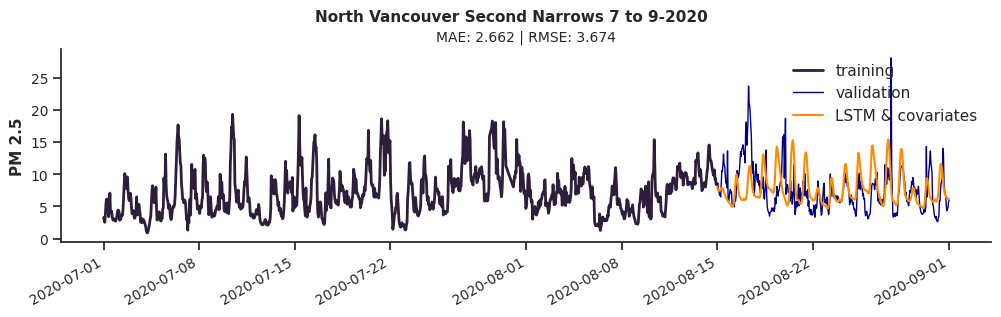

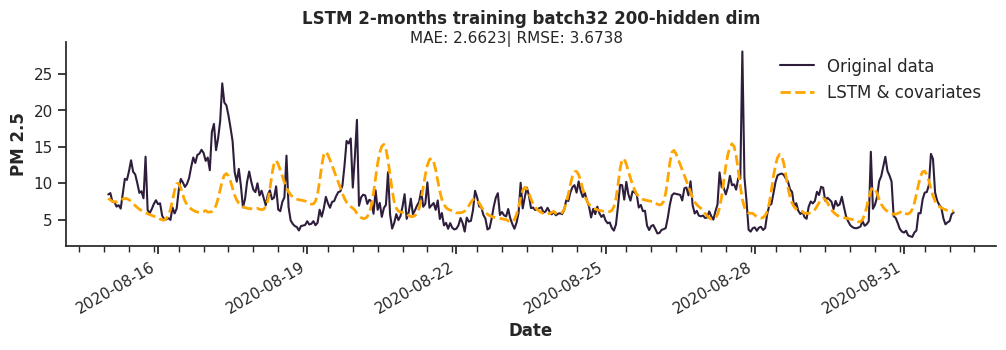

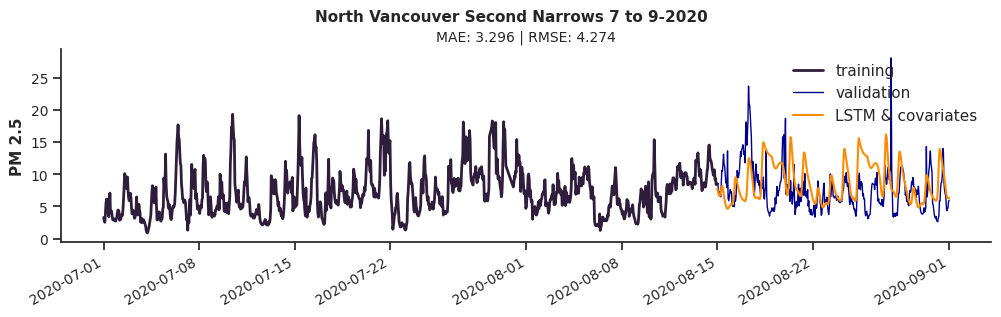

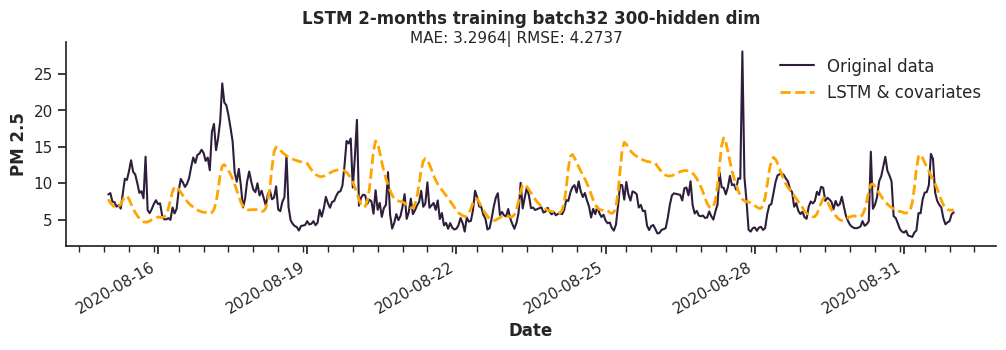

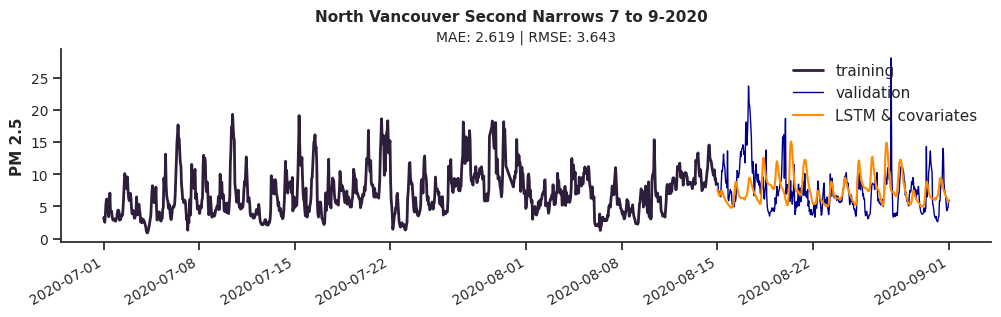

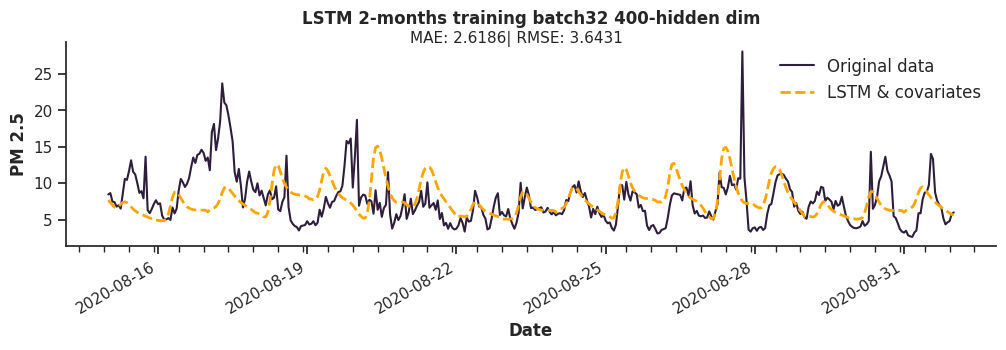

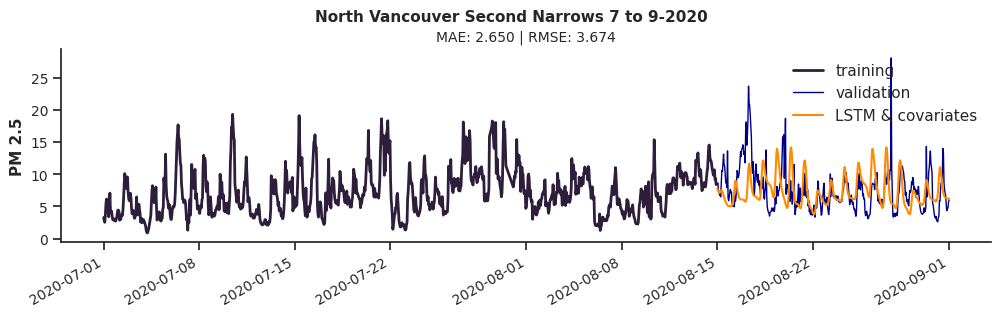

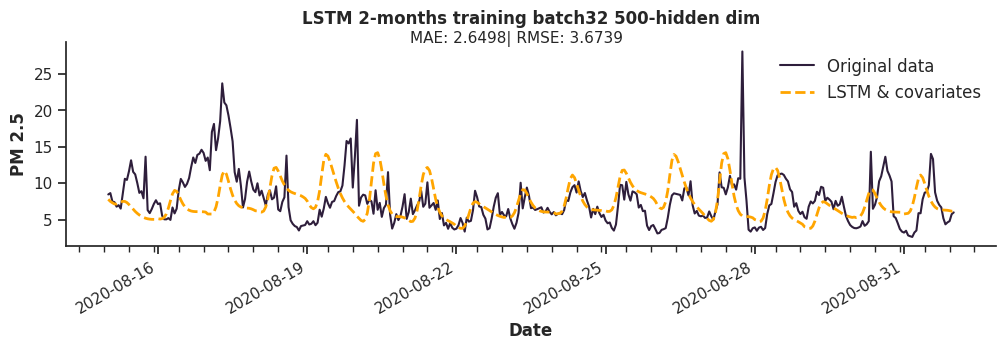

In [27]:
from tshelpers.plot import plot_compare
from tshelpers.metrics import mae_score, rmse_score

for model in results_dict.keys():
    train = results_dict[model]["train"]
    val = results_dict[model]["val"]
    pred_val = results_dict[model]["pred_val"]

    dart_plot(train,
        val,
        station="North Vancouver Second Narrows",
        month="7 to 9-2020",
        pred=pred_val,
        pred_label="LSTM & covariates")

    val_df = pd.DataFrame({"DATE_PST": val.time_index, "PM 2.5": [i[0] for i in val.values()]}).set_index("DATE_PST", drop=True)
    pred_df = pd.DataFrame({"DATE_PST": pred_val.time_index, "PM 2.5": [i[0] for i in pred_val.values()]}).set_index("DATE_PST", drop=True)

    plot_compare(
        pred_df,
        val_df,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=False,
        fill=False,
        data_label="LSTM & covariates",
        data_missing_label="Original data",
        plot_title=str(model).replace("_", " "),
        plot_sup_title=f"MAE: {mae_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}",
        figsize=(12, 3)
    )

In [28]:
# Redefining experimentation subsets to 2 months prior training set
subsets = {}
for station in stations:
    subsets[station] = {}
    for month, year in [(2, 2016), (11, 2017), (10, 2018), (8, 2020)]:
        subsets[station][f"{month}-{year}"] = master_df[master_df["STATION"] == station].loc[
    datetime(year, month-1, 1):datetime(year, month+1, 1), ["PM 2.5"]]

for station in subsets:
    print(station, subsets[station].keys())

# Darts timeseries64
for station in subsets:
    for month in subsets[station]:
        subsets[station][month] = TimeSeries.from_dataframe(subsets[station][month])

Vancouver_Clark_Drive_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
Vancouver_International_Airport_#2_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Mahon_Park_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Second_Narrows_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])


In [ ]:
# Iterating through stations subsets

for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.75)

        ## Creating month, year, and day-of-week covariates
        # Year covariates
        year_series = datetime_attribute_timeseries(
            pd.date_range(start=series.start_time(),
                            freq=series.freq_str,
                            periods=len(series)),
            attribute="year",
            one_hot=False,
        )

        # Weekday covariates
        weekday_series = datetime_attribute_timeseries(
            year_series, attribute="weekday", one_hot=True
        )

        # Hour covariates
        hour_series = datetime_attribute_timeseries(
            year_series, attribute="hour", one_hot=False
        )
        # Scaling hour covariates
        hour_series = Scaler().fit_transform(hour_series)

        covariates = weekday_series.stack(hour_series)
        cov_train, cov_val = covariates.split_before(pd.Timestamp(datetime(2020, 8, 15)))

        model_name = f"LSTM_2-months_training_batch32_400"
        results_dict[model_name] = {}

        # Early stopping
        stopper = EarlyStopping(
            monitor="val_loss",
            patience=10,
            min_delta=0.02,
            mode="min"
        )

        # LSTM model
        my_model = RNNModel(
            model="LSTM",
            hidden_dim=200,
            dropout=0.1,
            batch_size=32,
            n_epochs=100,
            optimizer_kwargs={"lr": 5e-4},
            model_name=model_name,
            log_tensorboard=True,
            random_state=123,
            training_length=20,
            input_chunk_length=21,
            force_reset=True,
            save_checkpoints=True,
            pl_trainer_kwargs={
                "callbacks": [stopper],
                "accelerator": "gpu",
                "devices": -1,
                "auto_select_gpus": True
            }
        )

        # Training
        my_model.fit(
            train,
            future_covariates=covariates,
            val_series=val,
            val_future_covariates=covariates,
            verbose=True,
        )

        # Validation
        pred_val = my_model.predict(n=len(val), future_covariates=covariates)
        my_model.load_from_checkpoint(model_name=model_name, best=True)

        # Storing results
        results_dict[model_name]["covariates"] = covariates
        results_dict[model_name]["train"] = train
        results_dict[model_name]["val"] = val
        results_dict[model_name]["pred_val"] = pred_val
        results_dict[model_name]["MAE"] = mae(pred_val, val)
        results_dict[model_name]["RMSE"] = rmse(pred_val, val)